# Linear Regression Model

### Set Up

In [206]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [207]:
# Importing test train splits

train_df = pd.read_csv("Data/train_set.csv")
test_df = pd.read_csv("Data/test_set.csv")

In [208]:
# Separating Features and Target

# Features
X_train = train_df.drop(columns=['Price', 'Log_Price', 'title', 'title_lower'], errors='ignore')
X_test = test_df.drop(columns=['Price', 'Log_Price', 'title', 'title_lower'], errors='ignore')

# Target
y_train = train_df['Log_Price']
y_test = test_df['Log_Price']


## Scaling Numeric Features 

In [209]:
X_train.dtypes

Mileage(miles)             int64
Registration_Year          int64
Previous Owners            int64
Engine                   float64
Doors                    float64
                          ...   
Usage_Level_Normal          bool
Usage_Level_Very High       bool
Door_Category_Family        bool
Door_Category_Sedan         bool
Door_Category_Small         bool
Length: 388, dtype: object

In [210]:
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns


In [211]:
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN in numeric columns
X_train = X_train.dropna(subset=numeric_cols)
y_train = y_train[X_train.index]  # align target
X_test = X_test.dropna(subset=numeric_cols)
y_test = y_test[X_test.index]


In [212]:
# Checking the count after dropping NaNs

X_train.count()

Mileage(miles)           2873
Registration_Year        2873
Previous Owners          2873
Engine                   2873
Doors                    2873
                         ... 
Usage_Level_Normal       2873
Usage_Level_Very High    2873
Door_Category_Family     2873
Door_Category_Sedan      2873
Door_Category_Small      2873
Length: 388, dtype: int64

In [213]:

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])


In [214]:
X_train = X_train.loc[:, X_train.nunique() > 1]
X_test = X_test[X_train.columns]  

In [215]:
numeric_cols = X_train.select_dtypes(include=np.number)
corr = numeric_cols.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
X_train = X_train.drop(columns=to_drop)
X_test = X_test[X_train.columns]

## Training the Linear Regression

In [216]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)

r2 = r2_score(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("R²:", r2)
print("MAE:", mae)
print("RMSE:", rmse)


R²: 0.8552631181621578
MAE: 0.21064590361751317
RMSE: 0.3037218741867037


## Examining Feature Importance

In [217]:
# Coefficients
coefs = pd.Series(model.coef_, index=X_train.columns)

# Sort by absolute value
importance = coefs.abs().sort_values(ascending=False)

# Top 20 most influential features
top_features = importance.head(20)
print(top_features)

# Optional: show direction (positive/negative impact)
print(coefs[top_features.index])

Model_Outlander          1.237611
Model_XM                 1.212008
Emission Class_Euro 4    1.200033
Brand_Mg                 1.167914
Brand_Rover              1.090518
Emission Class_Euro 5    1.086150
Emission Class_Euro 3    1.084933
Model_Stilo              1.038500
Brand_Suzuki             1.037815
Model_Bora               1.005826
Model_Focus C-max        0.985721
Emission Class_Euro 6    0.952535
Brand_Peugeot            0.905612
Brand_Jeep               0.903919
Model_Partner Tepee      0.868248
Brand_Vauxhall           0.867619
Model_Sharan             0.851966
Brand_Citroen            0.843519
Model_Shogun             0.834918
Model_Grand Espace       0.825863
dtype: float64
Model_Outlander         -1.237611
Model_XM                 1.212008
Emission Class_Euro 4   -1.200033
Brand_Mg                -1.167914
Brand_Rover             -1.090518
Emission Class_Euro 5   -1.086150
Emission Class_Euro 3   -1.084933
Model_Stilo             -1.038500
Brand_Suzuki            -1.037815

## Model Assumptions

## Residuals 

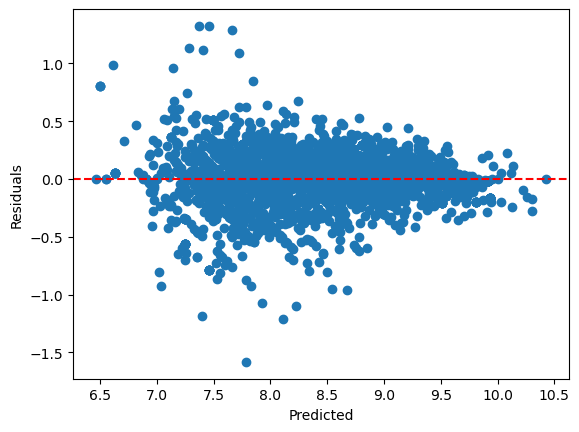

In [218]:
residuals = y_train - model.predict(X_train)
plt.scatter(model.predict(X_train), residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

## Homoscedacity 

<Axes: xlabel='Log_Price', ylabel='Count'>

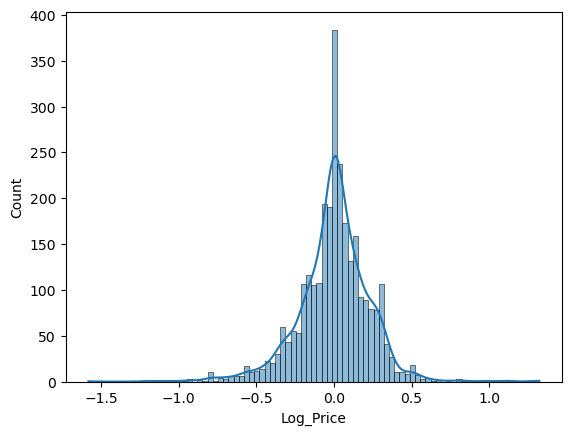

In [219]:
sns.histplot(residuals, kde=True)

## Evaluation

Residuals are centered around zero with no ovvious curve and a strong predictive accuracy.

Howver there is a larger spread at lower predicted values 7-8 and tighter spead at higher values 9-10. This means there is heteroscedacity and thew model predict expensive cars more accurately.

## Refine Features

- Removing features with coefficients near zero.

- Combing Sparse Categories

- Checking multicolinearity

In [220]:


X_numeric = X_train.select_dtypes(include=np.number)
vif = pd.DataFrame()
vif["feature"] = X_numeric.columns
vif["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]
print(vif.sort_values("VIF", ascending=False).head(30))


                feature          VIF
1     Registration_Year  3798.401115
0        Mileage(miles)    61.790101
13      Engine_per_Seat    11.606397
3                Engine    10.795959
8           Log_Mileage    10.335606
14          Premium_Age     7.429402
9            Is_Premium     7.177258
10        Mileage_Delta     5.665815
7      Mileage_per_Year     5.567642
5                 Seats     4.425747
11      Owners_per_Year     3.839663
2       Previous Owners     3.021844
12        Is_Family_Car     2.527502
4                 Doors     1.724872
6   Has_Service_History     1.063487


In [221]:

scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
print("CV R²:", scores, "Mean:", scores.mean())


CV R²: [0.87324567 0.86136297 0.89314841 0.86944921 0.86688738] Mean: 0.8728187274295628


In [222]:
y_pred_actual = np.exp(model.predict(X_test))
y_test_actual = np.exp(y_test)

mae_actual = np.mean(np.abs(y_test_actual - y_pred_actual))
print("MAE in actual price:", mae_actual)

MAE in actual price: 920.4555728521372


## Fix Multicollinearity 

In [223]:
drop_cols = [
    "Registration_Year",
    "Mileage(miles)",      # keep Log_Mileage instead
    "Engine_per_Seat",     # redundant
    "Is_Premium"           # redundant if brand dummies exist
]

X_train = X_train.drop(columns=[c for c in drop_cols if c in X_train.columns])
X_test = X_test.drop(columns=[c for c in drop_cols if c in X_test.columns])


In [224]:
X_test.columns

Index(['Previous Owners', 'Engine', 'Doors', 'Seats', 'Has_Service_History',
       'Mileage_per_Year', 'Log_Mileage', 'Mileage_Delta', 'Owners_per_Year',
       'Is_Family_Car',
       ...
       'Model_Ypsilon', 'Model_ZR', 'Model_Zafira', 'Model_Zafira Tourer',
       'Usage_Level_Low', 'Usage_Level_Normal', 'Usage_Level_Very High',
       'Door_Category_Family', 'Door_Category_Sedan', 'Door_Category_Small'],
      dtype='object', length=343)

In [225]:
import pickle

# Save X
with open("X_train.pkl", "wb") as f:
    pickle.dump(X_train, f)

with open("X_test.pkl", "wb") as f:
    pickle.dump(X_test, f)

# Save y
with open("y_train.pkl", "wb") as f:
    pickle.dump(y_train, f)

with open("y_test.pkl", "wb") as f:
    pickle.dump(y_test, f)

print("Train/test sets saved successfully.")


Train/test sets saved successfully.


In [226]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

print(X_train.columns[:5])
print(y_train.head())


(2873, 343) (718, 343)
(2873,) (718,)
Index(['Previous Owners', 'Engine', 'Doors', 'Seats', 'Has_Service_History'], dtype='object')
0    9.302920
1    8.004700
2    8.697847
3    8.778788
4    8.516993
Name: Log_Price, dtype: float64
